# "Anticipez les besoins en consommation électrique de bâtiments"
_Modelling Notebook_

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [45]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [46]:
if is_colab==True:
    
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


Noticing user about files that has to be in the current working directory.

In [47]:
def file_required(file_name):
    if os.path.exists(os.getcwd()+"/"+file_name):
        print("OK, loading "+file_name+"\
                           from the current working directory ...")
    else:
        print("Please, put "+file_name+"\
                           in the current working directory")

Installations and importations required for Google Colab version.

In [48]:
# !pip freeze > requirements_modelling.txt

In [49]:
import os

if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET4':
        os.chdir('My Drive/--DATA SCIENCE/PROJET4')
    !pip install -r requirements_modelling.txt
else:
    # make sure 'P4_functions.py' is in the current working directory
    file_required('/P4_functions.py')
    file_required('requirements_modelling.txt')
    !pip install -r requirements_modelling.txt

In [50]:
from P4_functions import *

Importation of modules and packages. 

In [51]:
import io
from time import time

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

import warnings
warnings.filterwarnings('ignore')

# from ipywidgets import interact, interact_manual

import dill

# from sklearn_pandas import DataFrameMapper

from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from mlxtend.plotting import plot_pca_correlation_graph
from sklearn.inspection import permutation_importance

import category_encoders as ce

import scipy.stats as st

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.linear_model import *
from sklearn import metrics
from sklearn.compose import make_column_transformer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

Setting pandas display options

In [52]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 500,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
    pd.set_option(k,v)

To play audio text-to-speech during execution.

In [53]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [54]:
speak('Packages and modules successfully imported')

### 0.1 Importing the dataset

In [55]:
if is_colab==True:
    path_csv = 'DATA/Cleaned_data.csv' 
    # Importing database from my Drive
    print("2. Try to import in notebook from myDrive...")
else:
    path_csv = '../DATA/Cleaned_data.csv'
    # Importing database from a DATA directory
    print("2. Try to import in notebook from PC ('DATA')")

df = pd.read_csv(path_csv, sep=',', index_col='Unnamed: 0',
                 low_memory=True, encoding ='utf-8')

print("-----> importation of .csv in the notebook OK")

2. Try to import in notebook from myDrive...
-----> importation of .csv in the notebook OK


In [56]:
df['ZipCode'] = df['ZipCode'].apply(str).astype('object')
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].apply(str).astype('object')

In [57]:
speak('Dataset successfully imported')

### 0.2 Overview

#### Brief description

In [58]:
df.shape

(1651, 65)

In [59]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier', 'ZipCode', 'La

Printing total nb and percentage of null

In [60]:
print_null_pct(df)

nb of null:  2191 
pct of null:  2.0


Showing columns where there are still NaN values

In [61]:
df.isna().sum(axis=0)[df.isna().sum(axis=0)!=0]

TaxParcelIdentificationNumber       1
ENERGYSTARScore                   542
Comments                         1648
dtype: int64

#### Checking the outliers

In [62]:
sel = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingAge','MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
       'ExtsurfVolRatio', 'ENERGYSTARScore']

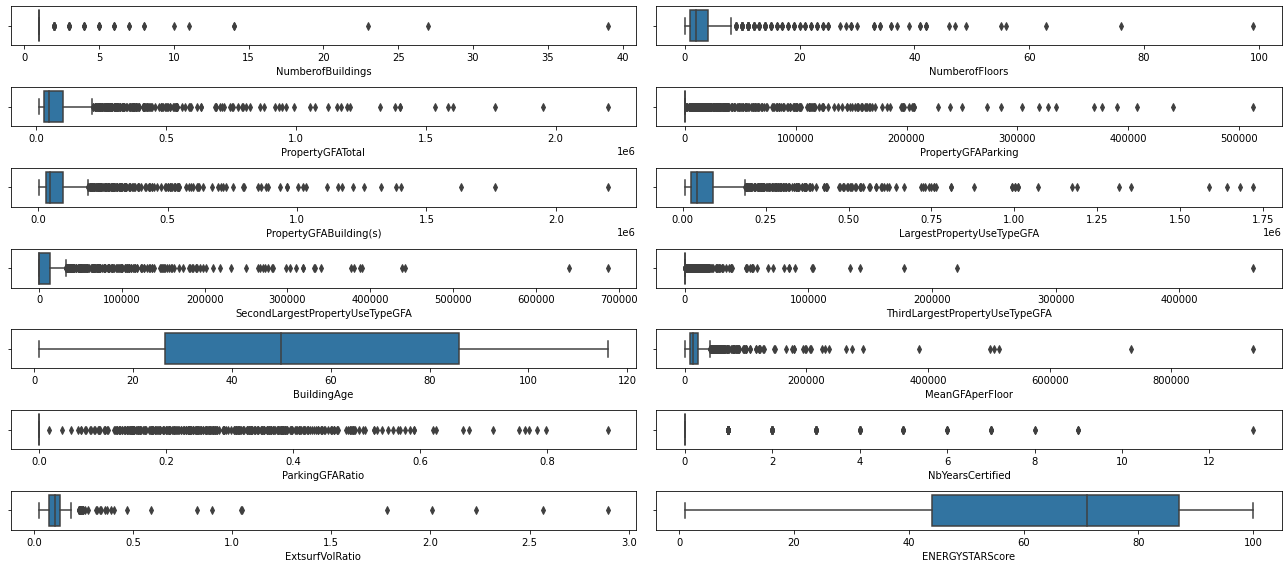

In [63]:
fig = plt.figure()
for i, c in enumerate(df[sel].columns,1):
    ax = fig.add_subplot(df[sel].shape[1]//2, 2, i)
    sns.boxplot(df[c], ax=ax)
fig.set_size_inches(18,8)
fig.tight_layout()

In [64]:
speak('Description overview done')

## 1 Data preprocessing

### 1.1 Target data transformation

We already found in the Cleaning_EDA notebook that the distribution of the target data could become almost normal with logarithmic transformation.

We'll test our models with and without this log transformation (see the 'set_dict_scv_params' function in P4_Modelling.py).

### 1.2 Feature transformation

We want to evaluate the impact of the transformation strategies for quantitative and categorical data. We'll split the columns in 4 types.

__Quantitative data__

Integers or float.

__Categorical data__

Categorical data are all nominal data, none of them are ordinal.
- Boolean : 'CertifiedPreviousYear'
- low cardinality (less than 12 categories):
'BuildingType', 'MainEnergy', 'EnergyProfile', 'Outlier'
- high cardinality (12 or more categories) :
('Neighborhood', 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType', 'PrimaryPropertyType')

The transformation of the columns is all (encoding of categorical and normalisation of quantitative) included in the Class CustTransformer (see P4_funtions.py file). The transformation options are passed to the GridSearchCV or RandomizedSearchCV through the param_grid dictionnary.

### 1.3 Features selection

Let's evaluate the quality and the colinearity of the features independent of the choice of the model to see if all features are worth keeping in the modelling process.

In [65]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio'] # 'ENERGYSTARScore',
prop_C_cols = ['Neighborhood', 'ZipCode', 'CouncilDistrictCode',
               'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
               'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
               'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy', 'Outlier']
target_cols = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']
                # 'SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']

#### Feature selection based on colinearity (Pearson correlation)

In [66]:
### SEUILLAGE DES COEFFICIENT DE CORRELATION

#### Feature selection based on colinearity (Variance Inflation Factor) 

In [67]:
#### ENCODAGE ORDINAL DES VALEURS CATEGORIELLES D'ABORD

# select_from_vif_(XXXXXXX, thresh=XXXXXXX)

#### Feature selection based on the variance of the data

In [68]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

#### ENCODAGE ORDINAL DES VALEURS CATEGORIELLES D'ABORD

# X_tr_Q = X_tr.select_dtypes(include=(np.number))
# for c in X_tr_Q.columns :
#     print(f"{c:-<40}{np.var(X_tr_Q.loc[:,c])}")

This analysis leads to the following conclusions:

__Quantitative data__

We noticed highly correlated quantitative features in the P4_Cleaning_Analysis notebook.
- 'PropertyGFATotal' is strongly correlated with 'PropertyGFABuilding(s)'
- 'PropertyGFABuilding(s)' is strongly correlated with 'LargestPropertyUseTypeGFA'
- 'ExtsurfVolRatio' is strongly correlated with 'NumberofBuildings'

__Categorical data__

- 'LargestPropertyUseType'(57) is strongly correlated with 'PrimaryPropertyType'(29)

At first, we'll keep all the data, except latitude and longitude, and identification data.
We'll put in place an automatic feature selection process in the pipeline we'll use for optimization.

In [69]:
df_X = df[prop_Q_cols+prop_C_cols]
df_y = df[target_cols] # 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'
# df_Xy = pd.concat([df_X, df_y], axis=1)

### 1.4 Outlier detection and labelling

We'll suppose a contamination of 5% of our data.

Only the X features will be considered in the outlier detection process, in order to allow for outlier detection in unseen data.

We'll label outliers using:
- Zscore on the quantitative columns
- LocalOutlierFactor
- IsolationForest

Let's see at first how the different thresholds impact on the data

In [70]:
from sklearn.model_selection import train_test_split

group_col = 'PrimaryPropertyType'
X_tr, _, y_tr, _ = train_test_split(df_X, df_y,
                                        train_size=0.8, shuffle=True,
                                        stratify=df_X[group_col],
                                        random_state=14)
# Selecting quantitative columns
X_tr_num = X_tr.select_dtypes(include=[np.number]).copy('deep')

# Encoding categorical features
ct = CustTransformer(strat_binary='ord',
                     strat_low_card='loo',
                     strat_high_card='loo',
                     strat_quant='none')
ct.fit(X_tr, y_tr['SiteEnergyUseWN(kBtu)'])
X_tr_enc = ct.transform_df(X_tr)
X_tr_enc.index = X_tr.index

#### Zscore

total nb of observations:  (1320, 13)


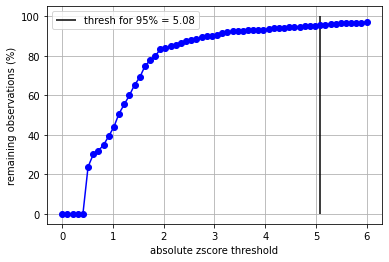

In [71]:
# ZSCORE PARTIE QUANTITATIVE

print("total nb of observations: ", X_tr_num.shape)
# Seuillage des données d'apprentissage en se basant sur le zscore (partie numérique seulement)
contamination_level_pct = 5
tab_shape=[]
thresholds = np.linspace(0,6,60)
for t in thresholds:
    zsf = ZscoreSampleFilter(thresh=t)
    df_ = zsf.fit_transform(X_tr_num)
    tab_shape.append(df_.shape[0]*100/X_tr_num.shape[0])
# Affichage du nombre de lignes restantes après filtrage selon le seuil
res = pd.DataFrame(tab_shape, index = thresholds)
thresh = res.loc[res.values>100-contamination_level_pct].idxmin()[0]
plt.plot(res, '-ob')
plt.vlines(thresh, 0, 100, label='thresh for {:.0f}% = {:.2f}'\
           .format(100-contamination_level_pct, thresh))
plt.xlabel("absolute zscore threshold")
plt.ylabel("remaining observations (%)")
plt.legend()
plt.grid()

#### LocalOutlierFactor

total nb of observations:  (1320, 25)


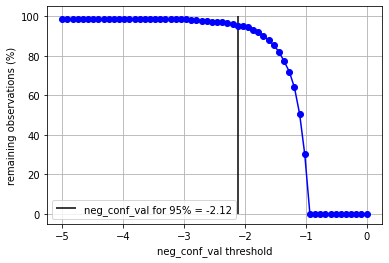

In [72]:
print("total nb of observations: ", X_tr_enc.shape)
# Seuillage des données d'apprentissage en se basant sur le zscore (partie numérique seulement)
contamination_level_pct = 5
neg_conf_vals = np.linspace(-5,0,60)
tab_shape=[]
for ncv in neg_conf_vals:
    loff = LOFSampleFilter(neg_conf_val=ncv, n_neighbors=20) # MODEL TRAINED ON THE TRAINING SET TO DETECT LOF OUTLIERS 
    df_ = loff.fit_transform(X_tr_enc)
    prop = df_.shape[0]*100/X_tr_enc.shape[0]
    tab_shape.append(prop)
# Affichage du nombre de lignes restantes après filtrage selon le seuil
res = pd.DataFrame(tab_shape, index = neg_conf_vals)
neg_conf_val = res.loc[res.values>100-contamination_level_pct].idxmin()[0]
plt.plot(res, '-ob')
plt.vlines(neg_conf_val, 0, 100, label='neg_conf_val for {:.0f}% = {:.2f}'\
           .format(100-contamination_level_pct, neg_conf_val))
plt.xlabel("neg_conf_val threshold")
plt.ylabel("remaining observations (%)")
plt.legend()
plt.grid()

#### IsolationForest

total nb of observations:  (1320, 25)


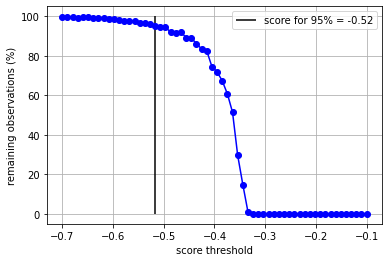

In [73]:
# ISOLATION FOREST (après encodage des valeurs catégorielles)

print("total nb of observations: ", X_tr_enc.shape)
# Seuillage des données d'apprentissage en se basant sur le zscore (partie numérique seulement)
contamination_level_pct = 5
score_samples_list = np.linspace(-0.1,-0.7,60)
tab_shape=[]
for sc in score_samples_list:
    isolf = IsolForestSampleFilter(score_samples=sc, n_estimators=100)
    df_ = isolf.fit_transform(X_tr_enc)
    prop = df_.shape[0]*100/X_tr_enc.shape[0]
    tab_shape.append(prop)
# Affichage du nombre de lignes restantes après filtrage selon le seuil
res = pd.DataFrame(tab_shape, index = score_samples_list)
score = res.loc[res.values>100-contamination_level_pct].idxmin()[0]
plt.plot(res, '-ob')
plt.vlines(score, 0, 100, label='score for {:.0f}% = {:.2f}'\
           .format(100-contamination_level_pct, score))
plt.xlabel("score threshold")
plt.ylabel("remaining observations (%)")
plt.legend()
plt.grid()

#### Comparison of the outliers algorithms

Let's now put the detection results by the three algorithms for the same contamination fraction in a dataframe.

In [74]:
'''detects the zscore threshold to put in the ZscoreSampleFilter in order
to use the proportion of contamination
May accept a dataframe with all dtype columns but selects
only numerical columns to compute the threshold'''

def Zscore_thresh_compute(df, contamination=0.05):
    df_num = df.select_dtypes(include=[np.number])
    tab_shape=[]
    thresholds = np.linspace(0,50,500)
    for t in thresholds:
        zsf = ZscoreSampleFilter(thresh=t)
        df_ = zsf.fit_transform(df_num)
        tab_shape.append(df_.shape[0]/df_num.shape[0])
    res = pd.DataFrame(tab_shape, index = thresholds)
    thresh = res.loc[res.values>1-contamination].idxmin()[0]
    return thresh

In [75]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

df_Xtr_outliers = pd.DataFrame(index=X_tr.index)

# zscore outlier detection column
df_Xtr_outliers['ZscoreOutlier'] = np.nan
thresh = Zscore_thresh_compute(X_tr_num, contamination=0.05) 
zsf = ZscoreSampleFilter(thresh=thresh)
zsf.fit(X_tr_num)
df_ = zsf.transform(X_tr_num)
df_Xtr_outliers.loc[df_.index, 'ZscoreOutlier'] = False
df_Xtr_outliers['ZscoreOutlier'] = \
  df_Xtr_outliers['ZscoreOutlier'].where(df_Xtr_outliers['ZscoreOutlier']==False,
                                         True)

# local outlier factor outlier dectection column
df_Xtr_outliers['LOFOutlier'] = np.nan
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
res = lof.fit_predict(X_tr_enc)
df_Xtr_outliers['LOFOutlier'] = \
        pd.Series(res, index = df_Xtr_outliers.index).map({-1: True, 1: False})

# isolation forest outlier detection column
df_Xtr_outliers['IsolFOutlier'] = np.nan
isolf = IsolationForest(n_estimators=100, contamination=0.05)
res = isolf.fit_predict(X_tr_enc)
df_Xtr_outliers['IsolFOutlier'] = \
        pd.Series(res, index = df_Xtr_outliers.index).map({-1: True, 1: False})


In [76]:
# Nb of outliers depending on the detection technique
df_Xtr_outliers.groupby(['ZscoreOutlier',
                     'LOFOutlier',
                     'IsolFOutlier']).size().reset_index()

,ZscoreOutlier,LOFOutlier,IsolFOutlier,0
0,False,False,False,1186
1,False,False,True,12
2,False,True,False,54
3,False,True,True,3
4,True,False,False,14
5,True,False,True,42
6,True,True,True,9


The 3 outlier detection techniques has led to very different selection of outliers.

On 83 outliers detected (5% of 1651) by each algoriths, only:
- 56+7=63 are both considered as outliers by Zscore and IsolationForest
- 0+7=7 are both considered as outliers by LocalOulierFactor and IsolationForest
- 4+7=11 is considered as outliers by Zscore and LocalOutlierFactor
- 7 are considerd as outliers by the three algorithms at the same time.

We should expect different results on out models while filtering with each method.

Let's see if the outliers detected are homogeneously picked among the different categories or if we can find a particular pattern in the outliers.

- histograms of the whole training dataset compared to the histograms of the outliers:

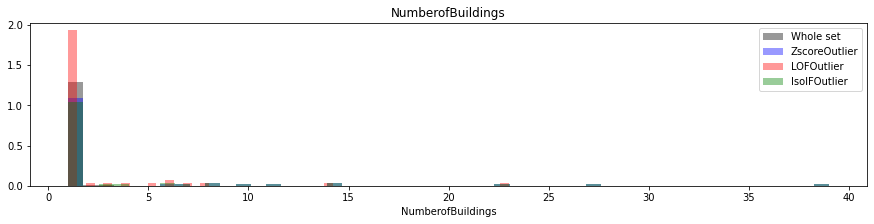

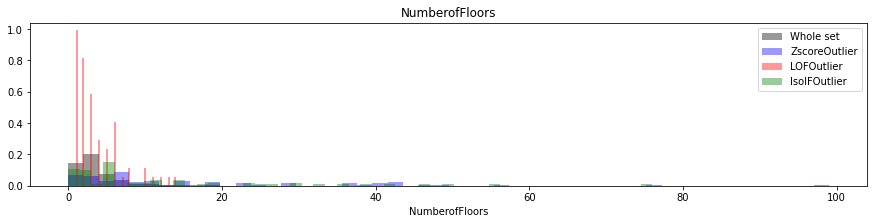

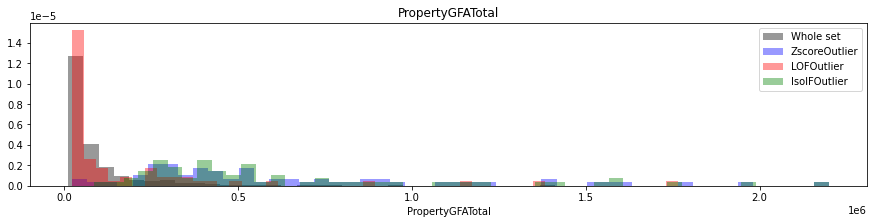

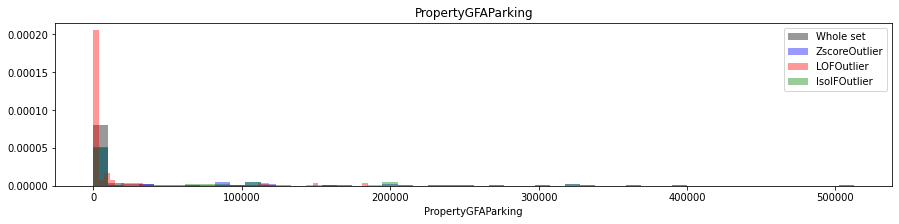

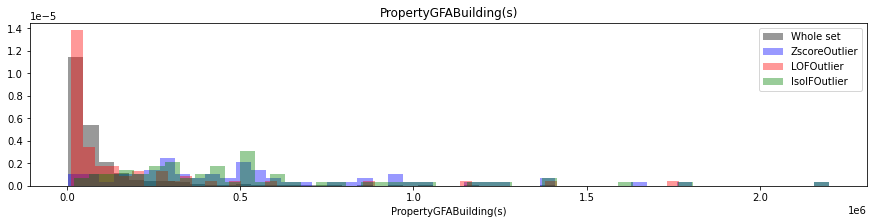

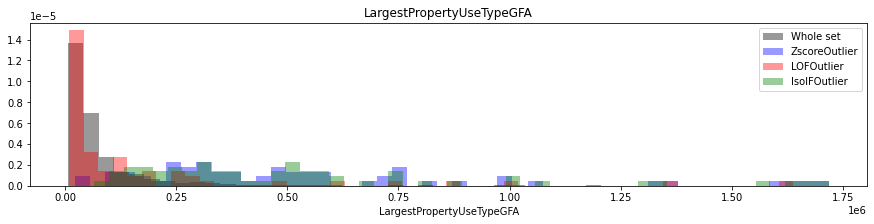

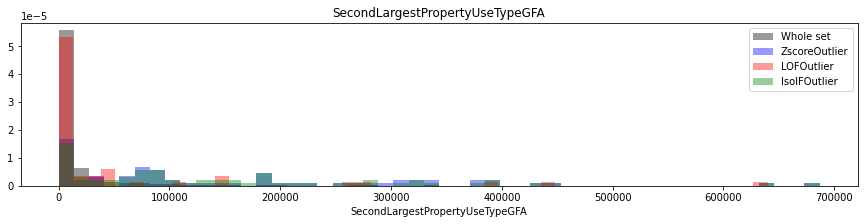

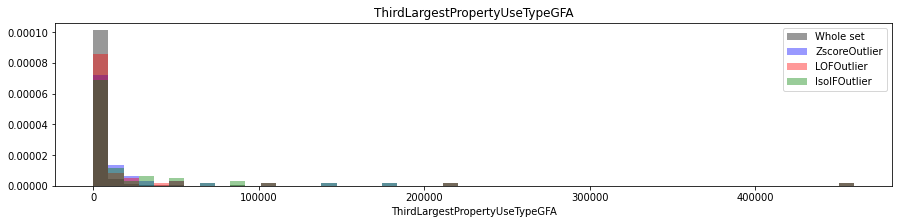

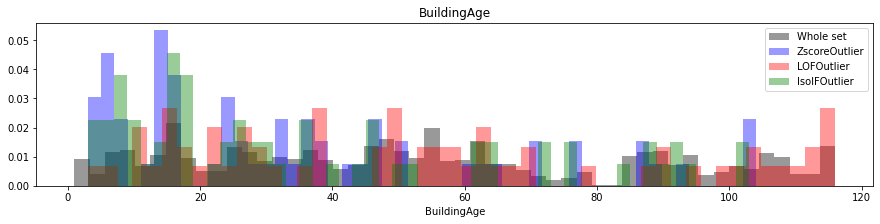

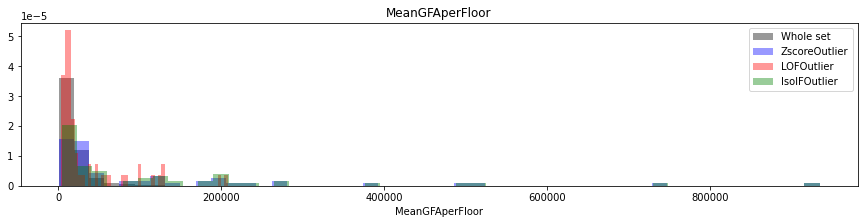

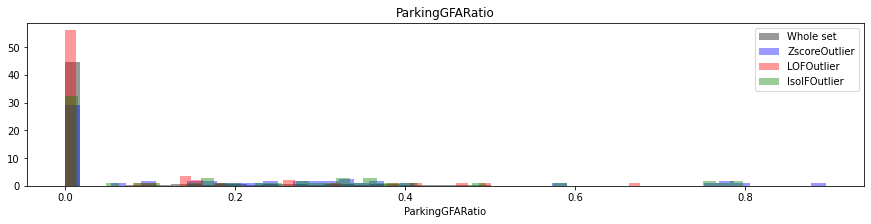

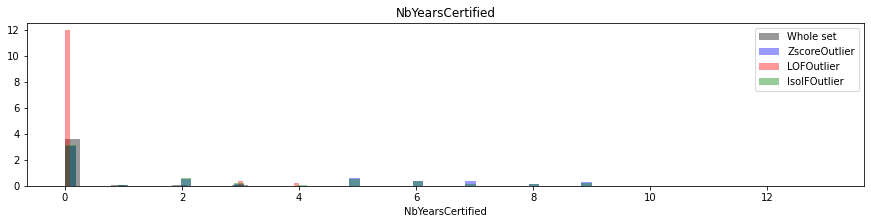

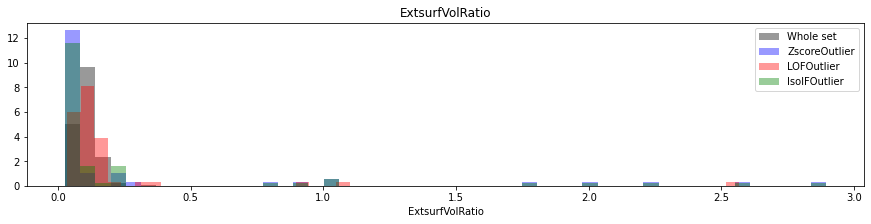

In [77]:
# df_Xtr_outliers is calculated in §1.4
colors = ['b', 'r', 'g']
for col in prop_Q_cols:
    fig, ax = plt.subplots(1, figsize=(15,3))
    sns.distplot(df[col], bins=50, color='k', kde=False, norm_hist=True, ax=ax, label='Whole set')
    for outlier_type, c in zip(['ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'], colors):
        out_ind = df_Xtr_outliers[df_Xtr_outliers[outlier_type]==True].index
        df_ = df_X.loc[df_X.index.isin(out_ind)]
        sns.distplot(df_[col], bins=50, color=c, kde=False, norm_hist=True,
                      ax=ax, label=outlier_type)
        ax.set_title(col)
    ax.legend()

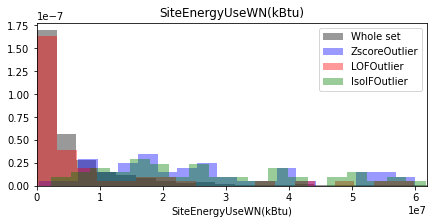

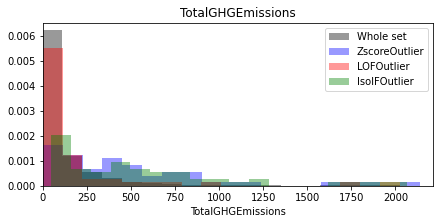

In [78]:
# df_Xtr_outliers is calculated in §1.4
colors = ['b', 'r', 'g']
for col in target_cols:
    fig, ax = plt.subplots(1, figsize=(7,3))
    sns.distplot(df[col], bins=150, color='k', kde=False, norm_hist=True, ax=ax, label='Whole set')
    for outlier_type, c in zip(['ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'], colors):
        out_ind = df_Xtr_outliers[df_Xtr_outliers[outlier_type]==True].index
        df_ = df_y.loc[df_y.index.isin(out_ind)]
        # ind = X_tr[df_Xtr_outliers[outlier_type] == True].index
        # df_ = df.loc[ind]
        sns.distplot(df_[col], bins=150, color=c, kde=False, norm_hist=True,
                      ax=ax, label=outlier_type)
        ax.set_title(col)
        xmin, xmax = ax.get_xlim()
        ax.set(xlim=(0, xmax/2))
    ax.legend()

- bar plot comparing the distribution of the categorical data of the whole dataset, and that of the outliers subdatasets 

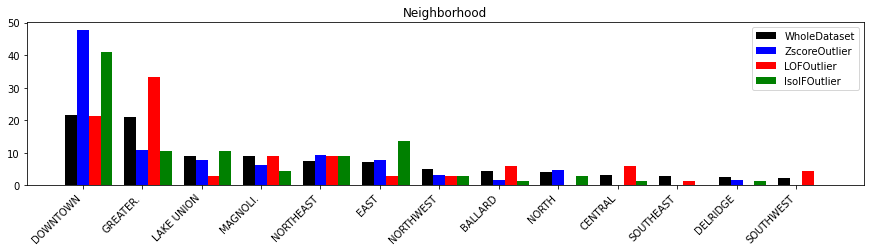

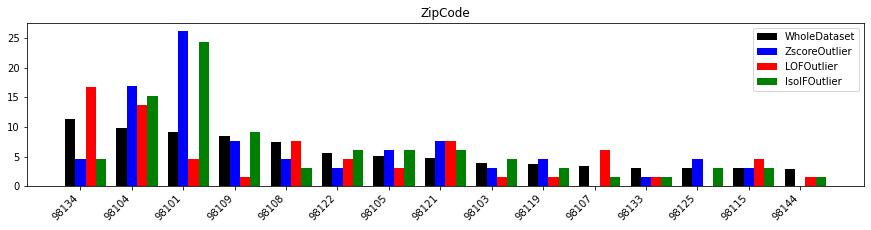

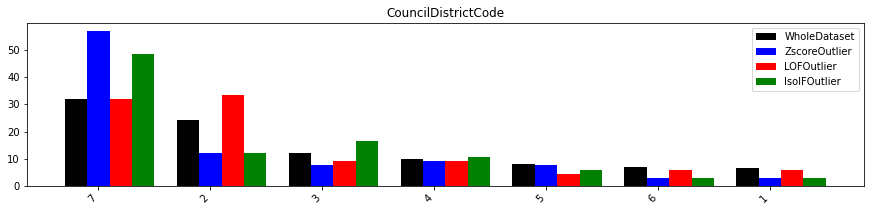

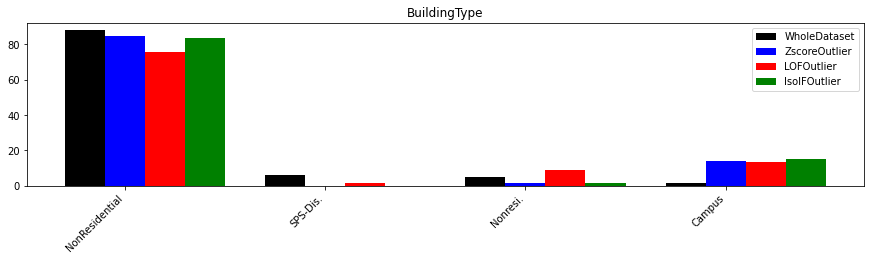

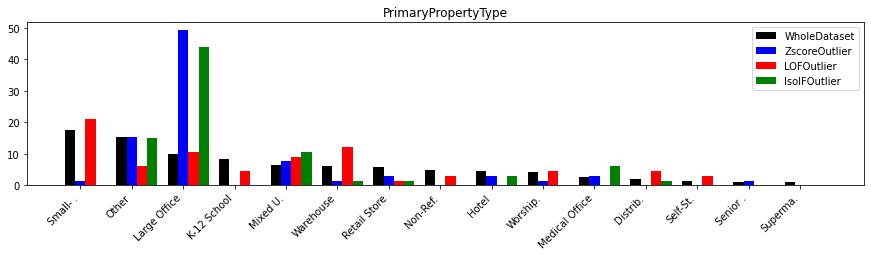

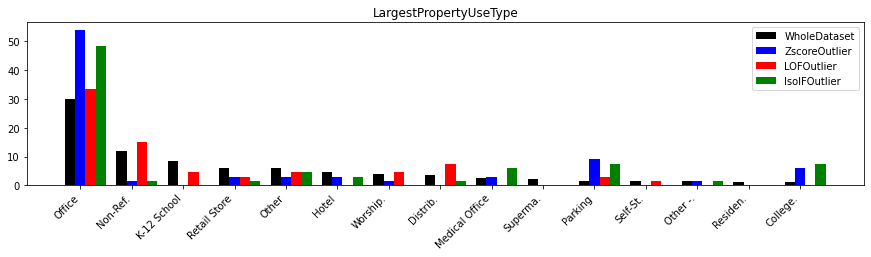

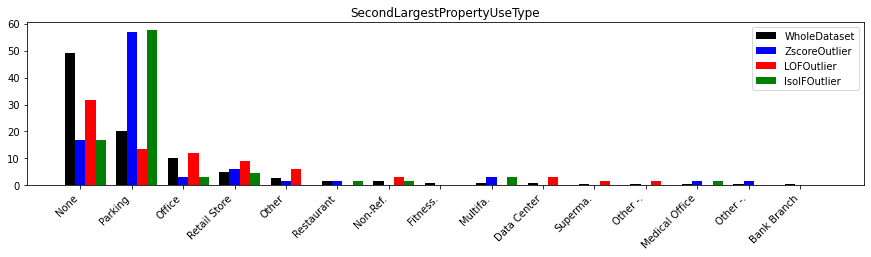

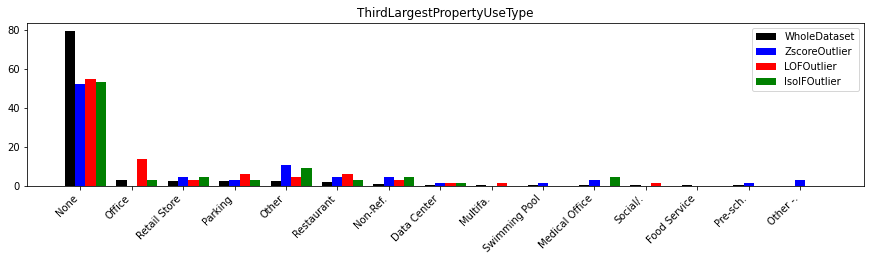

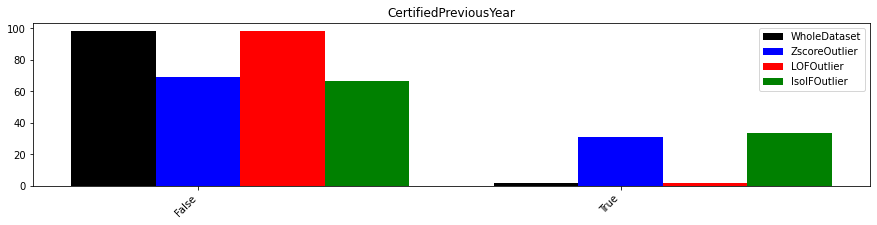

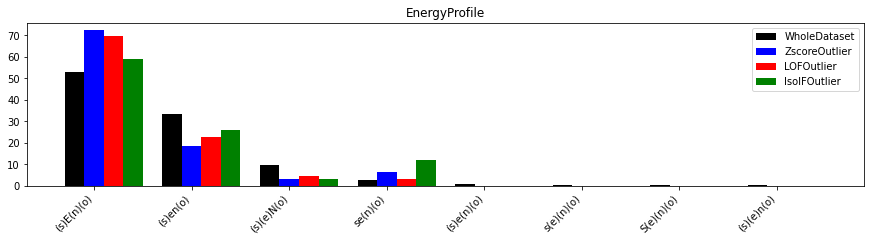

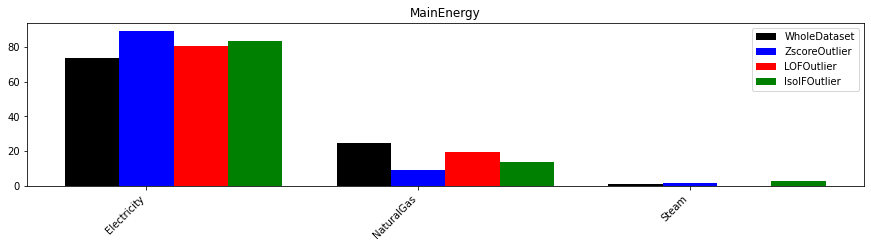

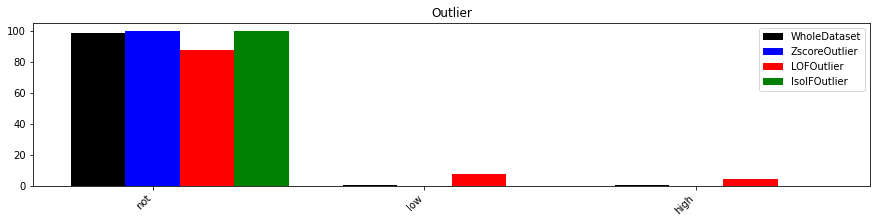

In [79]:
# df_X_outliers is calculated in §1.4
colors = ['k','b', 'r', 'g']

for col in prop_C_cols:

    fig, ax = plt.subplots(1, figsize=(15,3))
    val_count_pct = (df_X[col].value_counts()).div(df_X.shape[0])*100
    df_val_c_out = pd.DataFrame(data = val_count_pct.values, index=val_count_pct.index, columns=['WholeDataset'])
    for i, (outlier_type) in enumerate(['ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'],1):
        out_ind = df_Xtr_outliers[df_Xtr_outliers[outlier_type]==True].index
        df_ = df_X.loc[df_X.index.isin(out_ind)]
        # df_ = X_tr[df_Xtr_outliers[outlier_type] == True]
        val_count_pct = pd.Series((df_[col].value_counts()).div(df_.shape[0])*100, name=outlier_type)
        df_val_c_out = pd.concat([df_val_c_out, val_count_pct.to_frame()],axis=1)
    for i, (outlier_type, c) in enumerate(zip(['WholeDataset', 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'], colors),1):
        ser = df_val_c_out[outlier_type].fillna(0)[0:15]
        p = np.arange(0, ser.shape[0])
        w = 0.2
        ax.bar(x=p+w*i, height=ser.values, width=w, color=c, label=outlier_type)
        ax.set_xticks((p+4*w)-w*4/2)
        short_labels = [str(s)[0:7]+'.' if len(str(s))>15 else s for s in ser.index]
        ax.set_xticklabels(short_labels)
        plt.xticks(rotation=45, ha='right')
        ax.set_title(col)
    ax.legend()
    plt.show()


The Zscore and the Isolation Forest algorithm detected mainly properties from "Downtown" labelled as "Large Office" (PrimaryPropertyUseType, LargestPropertyUseType) provided with "parkings" (SecondLargestPropertyUseType) and a large Number of Floors. the Ground Floor Area (GFA) also seem to be higher, even though values show a large dispersion.

The Ground Floor Area (GFA) of the outliers detected by the Local Outlier Factor algorithms are also clearly shifted to the right (medium values) (LargestPropertyUseType, TotalGFABuilding(s), PropertyGFATotal), but the usage types are either 'Other', 'Warehouse' or 'Non ref' and mostly situated in the 'Greater Duwamish'.

This indicates that, if we purely drop one of these outliers group from the training set, we may miss some important information that would allow to predict correctly SEU and GHG of the certain types of buildings. However, this also means that each group of outliers form a coherent subset that may be successfully modelled apart in a subsidiary model.

### 1.5 Splitting training and testing set

We want our model to give homogeneous results on all the 'PrimaryPropertyType' modalities.

We thus split the data with stratification using this column.

In [80]:
## OLD CODE, WITHOUT OUTLIER FILTERING
# X_tr, X_te, y_tr, y_te = train_test_split(df_X, df_y,
#                                             train_size=0.8, shuffle=True,
#                                             stratify=df[group_col],
#                                             random_state=14)

In [81]:
''' to get a train and test test from the data using an
 outlier filtering strategy, use the following code :
______________________________
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_X_outliers, # df_X_outliers is calculated in §1.4
                                      'SEU', 'IsolFOutlier', group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
______________________________'''

def tr_te_split_with_outliers_filter(dfX, dfy, df_Xtr_outliers, target, 
                                         strategy, group_col):
    # targets : 'SEU', 'GHG'
    # strategies : 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier', None
    d_cols={'SEU': 'SiteEnergyUseWN(kBtu)', 'GHG': 'TotalGHGEmissions'}
    
    # Whole train and test sets
    X_tr, X_te, y_tr, y_te = train_test_split(dfX, dfy[d_cols[target]],
                                        train_size=0.8, shuffle=True,
                                        stratify=dfX[group_col],
                                        random_state=14)
    
    if strategy is not None:
        ind_drop = df_Xtr_outliers[df_Xtr_outliers[strategy]==True].index
        X_tr, y_tr = X_tr.drop(index=ind_drop), y_tr.drop(index=ind_drop)

    return X_tr, X_te, y_tr, y_te # train without outliers / test with outlier

In [82]:
group_col = 'PrimaryPropertyType'

In [83]:
# sample data without outliers filtering
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_X_outliers is calculated in §1.4
                                      'SEU', 'LOFOutlier', group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape # all : ((1320, 25), (331, 25), (1320, 2), (331, 2)) 'LOF : ((1254, 25), (331, 25), (1254,), (331,))

((1254, 25), (331, 25), (1254,), (331,))

Printing the quantitative and categorical independent columns:

In [84]:
print(f'--- {X_tr.columns.shape[0]} independent columns ---\
\nquantitative ({len(prop_Q_cols)}): {prop_Q_cols},\
\ncategorical ({len(prop_C_cols)}): {prop_C_cols}')

--- 25 independent columns ---
quantitative (13): ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'BuildingAge', 'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified', 'ExtsurfVolRatio'],
categorical (12): ['Neighborhood', 'ZipCode', 'CouncilDistrictCode', 'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy', 'Outlier']


In [85]:
print(f'--- {len(target_cols)} target columns ---\
\nquantitative ({len(target_cols)}): {target_cols}')

--- 2 target columns ---
quantitative (2): ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']


## 2 Modelling settings

### 2.0 Defining the target

We'll make available to choose between the 2 targets and to choose wether we try to model y or log(y). The function 'set_dict_scv_params' in "P4_Modelling.py" returns: 

- the name of the dumping file (SEU or GHG) for model and learning curve
- the metrics (cv scores and refit score) using log or not
- the values of y (log or not)

The result of the two latter is stored in variable "dict_scv_params".

### 2.1 Setting a mean to save the computed data

Creating a pickle (if it does not exist yet) or use the existing pickle, and creates the dict_model dictionary that will contain all the models.

In [86]:
def load_pickle(f_name):
# If file of models exists, open and load in dict_model
    if os.path.exists(f_name):
        with open(f_name, "rb") as f:
            d_file = dill.load(f)
        print('--Pickle containing models already existing as ',
              f_name, ':\n', d_file.keys())
        print("Content loaded from '", f_name, "'.")
        return d_file
    # Else create an empty dictionary
    else:
        print('--No pickle yet as ',f_name)
        return {}

In [87]:

dict_SEU_models = load_pickle("P4_models_SEU.pkl")
dict_GHG_models = load_pickle("P4_models_GHG.pkl")

dict_SEU_lcurves = load_pickle("P4_lcurves_SEU.pkl")
dict_GHG_lcurves = load_pickle("P4_lcurves_GHG.pkl")

dict_SEU_pimp = load_pickle("P4_pimp_SEU.pkl")
dict_GHG_pimp = load_pickle("P4_pimp_GHG.pkl")

--No pickle yet as  P4_models_SEU.pkl
--No pickle yet as  P4_models_GHG.pkl
--No pickle yet as  P4_lcurves_SEU.pkl
--No pickle yet as  P4_lcurves_GHG.pkl
--No pickle yet as  P4_pimp_SEU.pkl
--No pickle yet as  P4_pimp_GHG.pkl


In [88]:
dict_models = dict_SEU_models
dict_lcurves = dict_SEU_lcurves
dict_pimp = dict_SEU_pimp

Defining a dataframe to store the results.

In [89]:
df_res = pd.DataFrame(dtype = 'object')

### 2.2 Defining evaluation functions



We'll will use 5 different metrics to evaluate and select the model throughout the optimization process (see P4_functions.py):
- R2 (Coefficient of determination)
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- MPSE (Mean Percent Squared Error)
- Rate of predictions within 90-110% of true value

NB: when switching in "log" mode of the target, we'll use a version of the metric that takes into account the need for "inverse transformation" of the target to compute the score (see P4_functions.py).

### 2.3 Defining folds for cross-validation

We'll stratify the folds as we did for the split of the training set and the test set.

In [90]:
# skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

In [91]:
speak("preprocessing done")

### 2.4 Effect of outlier filtering on a KNN Regressor (SEU model)

Let's see at first how the outliers are impacting the train score and then the test score.

We can expect the outliers to induce poorer scores on the train set and this is normal. But can we determine wether the training set outliers are altering the ability of the model to generalize or not ?

To attempt to answer this question, we'll train and optimize a KNN model with and without outliers, and compare the cross-validation scores on the training set, as well as the scores on the test set.


* __Training set with outliers__

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

group_col = 'PrimaryPropertyType'
target = 'SEU'
outlier_filt_strat = None
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_X_outliers is calculated in §1.4
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'wd_KNN_kneigh_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,4,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model not existing - computing...
Grid
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   52.9s finished


-----...model dumped


* __Training set with elimination of 5% of outliers (Zscore detection)__

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

target = 'SEU'
outlier_filt_strat = 'ZscoreOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_X_outliers is calculated in §1.4
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'zo_KNN_kneigh_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,4,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model not existing - computing...
Grid
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   47.5s finished


-----...model dumped


* __Training set with elimination of 5% of outliers (LocalOutlierFactor detection)__

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

target = 'SEU'
outlier_filt_strat = 'LOFOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_X_outliers is calculated in §1.4
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'lo_KNN_kneigh_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,4,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model not existing - computing...
Grid
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   47.1s finished


-----...model dumped


In [95]:
# name_reg = 'wd_KNN_kneigh_grid'
# dict_models[name_reg].best_params_

In [96]:
# # Multiscoring with hyperparameter tuning
# scv = dict_models[name_reg]
# plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
#                       title = None, figsize = (15, 3))

* __Training set with elimination of 5% of outliers (IsolationForest detection)__

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

target = 'SEU'
outlier_filt_strat = 'IsolFOutlier'
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_X_outliers is calculated in §1.4
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'io_KNN_kneigh_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,4,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model not existing - computing...
Grid
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   46.9s finished


-----...model dumped


* __Comparison of the models with and without outliers__

We've found the best KNN model for three different outlier filtering algorithms applied to the same training set. We hope that this outlier filtering will increase the ability of the model to generalize on a test set never seen before.

Let's check if it is the case.

In [98]:
# Cross-validation scores on training set
names = df_res.columns[df_res.columns.str.contains('KNN')]
lines = df_res.index[df_res.index.str.startswith('mean_test')]
df_res.loc[lines, names]

,wd_KNN_kneigh_grid,zo_KNN_kneigh_grid,lo_KNN_kneigh_grid,io_KNN_kneigh_grid
mean_test_r2,0.43,0.41,0.51,0.48
mean_test_mae,-4656941.17,-3195774.60,-3682022.42,-2913430.07
mean_test_rmse,-16771173.42,-8211003.95,-8700587.98,-6307337.60
mean_test_mpse,-3830.18,-1391.28,-4239.74,-1774.29
mean_test_pred_rate_10,0.12,0.12,0.11,0.13


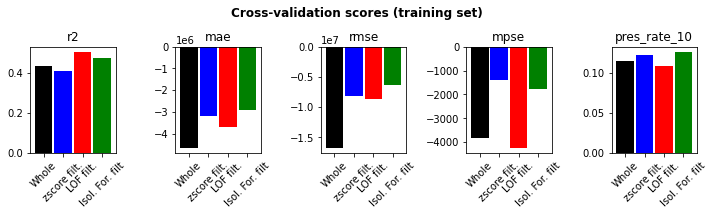

In [99]:
# Plotting the results
fig = plt.figure(figsize=(10,3))
titles = ['r2', 'mae', 'rmse', 'mpse', 'pres_rate_10']
for i, (l, t) in enumerate(zip(lines, titles), 1):
    # l = 'mean_test_r2'
    ax = fig.add_subplot(1,len(lines),i)
    for n in names:
        df_res.loc[l, names].plot.bar(width=0.9, color=['k', 'b', 'r', 'g'], ax=ax)
        ax.set_xticklabels(['Whole', 'zscore filt.', 'LOF filt.', 'Isol. For. filt'])
        ax.tick_params('x', rotation=45)
    ax.set_title(t)
fig.suptitle("Cross-validation scores (training set)", fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

In [100]:
# Scores on test set
df_test = pd.DataFrame()
names = ['wd_KNN_kneigh_grid']+[pre+'o_KNN_kneigh_grid' for pre in ['z', 'l', 'i']]
for n in names:
    model = dict_models[n].best_estimator_
    df_ = compute_test_scores(n, model, X_te, y_te, scoring_test=dict_scv_params['scv_scores'])
    df_test = pd.concat([df_test, df_], axis=1)
df_test

,wd_KNN_kneigh_grid,zo_KNN_kneigh_grid,lo_KNN_kneigh_grid,io_KNN_kneigh_grid
r2,0.30,0.29,0.32,0.24
mae,-4886627.26,-4692298.04,-4639287.55,-4947727.18
rmse,-18963036.63,-19103295.24,-18791347.58,-19854678.65
mpse,-1282.85,-1630.35,-1598.24,-1575.81
pred_rate_10,0.11,0.11,0.20,0.13


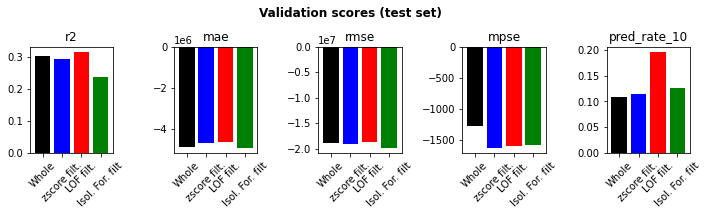

In [101]:
# Plotting the results
fig = plt.figure(figsize=(10,3))
for i, l in enumerate(df_test.index, 1):
    # l = 'mean_test_r2'
    ax = fig.add_subplot(1,len(lines),i)
    for n in names:
        df_test.loc[l, names].plot.bar(width=0.8, color=['k', 'b', 'r', 'g'], ax=ax)
        ax.set_xticklabels(['Whole', 'zscore filt.', 'LOF filt.', 'Isol. For. filt'])
        ax.tick_params('x', rotation=45)
    ax.set_title(l)
fig.suptitle("Validation scores (test set)", fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

- Comparison of errors in the test set

In [102]:
# Prediction errors (test set)
df_mae, df_mpse = pd.DataFrame(), pd.DataFrame()
names = ['wd_KNN_kneigh_grid']+[pre+'o_KNN_kneigh_grid' for pre in ['z', 'l', 'i']]
for n in names:
    model = dict_models[n].best_estimator_
    y_pr = model.predict(X_te)

    mae_ = pd.DataFrame(data=(y_pr-y_te).values, index=y_te.index, columns=[n])
    mpse_ = pd.DataFrame(data=(100*np.square((y_pr-y_te)/y_te)).values, index=y_te.index, columns=[n])

    df_mae = pd.concat([df_mae, mae_], axis=1)
    df_mpse = pd.concat([df_mpse, mpse_], axis=1)

display(df_mae.head(5), df_mpse.head(5))

,wd_KNN_kneigh_grid,zo_KNN_kneigh_grid,lo_KNN_kneigh_grid,io_KNN_kneigh_grid
6504,-120466621.80,-135480376.12,-132749655.73,-156438857.45
5014,1275822.10,1124565.32,1235508.21,1124565.32
3483,-3382053.60,-1103323.07,-4561844.31,-4155582.53
112,654651.70,863754.96,-188925.62,863754.96
1061,-1010807.53,-2918759.96,-4586239.57,-3040623.97


,wd_KNN_kneigh_grid,zo_KNN_kneigh_grid,lo_KNN_kneigh_grid,io_KNN_kneigh_grid
6504,52.33,66.19,63.55,88.25
5014,1385.99,1076.84,1299.79,1076.84
3483,15.64,1.66,28.46,23.61
112,2.97,5.16,0.25,5.16
1061,0.91,7.55,18.64,8.19


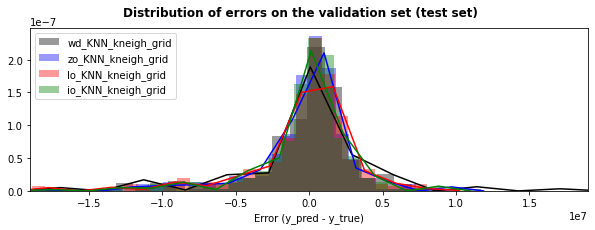

In [103]:
# Error distribution
fig = plt.figure(figsize=(10,3))
colors=['k', 'b', 'r', 'g']
for n,c in zip(names, colors):
    sns.distplot(df_mae[n], bins=300, color=c, kde=True, label=n)
    plt.gca().legend(loc=2)
    plt.gca().set(xlim=(-1.9e7, 1.9e7))
plt.gca().set_xlabel("Error (y_pred - y_true)")
fig.suptitle("Distribution of errors on the validation set (test set)", fontweight='bold');

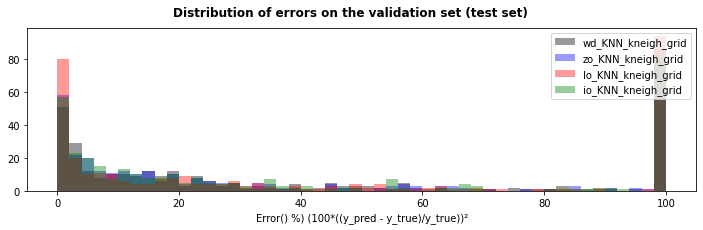

In [104]:
# Error distribution (pct)
fig = plt.figure(figsize=(12,3))
colors=['k', 'b', 'r', 'g']
for n,c in zip(names, colors):
    sns.distplot(df_mpse[n].clip(0,100), bins=50, color=c, hist=True, kde=False, label=n)
    plt.gca().legend(loc=1)
    # plt.gca().set(xlim=(0, 20000))
plt.gca().set_xlabel("Error() %) (100*((y_pred - y_true)/y_true))²")
fig.suptitle("Distribution of errors on the validation set (test set)", fontweight='bold');

- Modelling the outliers

In [105]:
lof_ind = df_Xtr_outliers[df_Xtr_outliers['LOFOutlier']==True].index

In [106]:
len(lof_ind), df_Xtr_outliers.shape

(66, (1320, 3))

In [107]:
# récupérer les index des  outliers LOF présents dans le jeu de train
# former X_tr_out() et y_tr_out
# Faire un modèle KNN de ces 66 outliers
# (obtenir les scores de cross-val sur ce jeu de train)
# faire passer sur X_te le détecteur d'outliers -> X_te_wo, y_te_wo et X_te_out , y_te_out

In [108]:
target = 'SEU'
outlier_filt_strat = None
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_X_outliers is calculated in §1.4
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
X_tr = X_tr[X_tr.index.isin(lof_ind)]
y_tr = y_tr[y_tr.index.isin(lof_ind)]
X_tr.shape, y_tr.shape

((66, 25), (66,))

In [109]:
# lof.fit_predict(X_te)

In [110]:
# from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsRegressor

# target = 'SEU'
# outlier_filt_strat = None
# X_tr, X_te, y_tr, y_te = \
#      tr_te_split_with_outliers_filter(df_X, df_y, df_X_outliers, # df_X_outliers is calculated in §1.4
#                                       target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
# X_tr_o = X_tr[X_tr.index.isin(lof_ind)]

# skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

# reg = KNeighborsRegressor()
# name_reg = 'OUT_io_KNN_kneigh_grid'
# # del dict_models[name_reg] # to overwrite an existing model
# param_grid={'preproc__cust_trans__strat_binary': ['ord'],
#             'preproc__cust_trans__strat_low_card': ['ohe', 'bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_high_card': ['ohe', 'bin', 'ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_quant': ['stand', 'robust', 'quant_norm', 'yeo'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
#             name_reg+'__n_neighbors': [1,2,3,4,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
#             name_reg+'__p': [1,2]} # 1,2
# search_strat = 'grid'
# n_iter=None
# refit_score='r2'

# preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
# pipe = Pipeline([('preproc', preproc_pipe),
# 	             (name_reg, reg)])
# dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
#         set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

# df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
#                           pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

## 3 Regression Models for 'SEU'

In [111]:
# # Best parameters
# dict_models[name_reg].best_params_

# # Multiscoring with hyperparameter tuning
# scv = dict_models[name_reg]
# plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
#                       title = None, figsize = (15, 3))

# # Effect of encoding on performance
# # (The score displayed for each cell is the one for the best other parameters_)
# param1 = name_reg+'__'+'n_neighbors'
# param2 = name_reg+'__'+'p'
# param3 = 'preproc__cust_trans__strat_low_card'
# param4 = 'preproc__cust_trans__strat_high_card'
# param5 = 'preproc__cust_trans__strat_quant'
# fig = plt.figure(figsize=(20,3))
# ax = fig.add_subplot(1,4,1)
# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
#                        score = 'r2', ax=ax)
# ax = fig.add_subplot(1,4,2)
# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
#                        score = 'r2', ax=ax)
# ax = fig.add_subplot(1,4,3)
# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
#                        score = 'r2', ax=ax)
# ax = fig.add_subplot(1,4,4)
# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
#                        score = 'r2', ax=ax)

# # Learning curve
# # del dict_lcurves[name_reg] # to overwrite an existing learning curve
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# # title = f"Learning Curves ({name_reg})"
# model = dict_models[name_reg].best_estimator_
# plot_learning_curve(name_reg, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
#                     cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
#                     file_name=l_curves_file_name,
#                     dict_learn_curves=dict_lcurves,
#                     train_sizes = np.linspace(0.1,1,15),
#                     c='b', axes=axes, title=None)
# plt.show()

CONCLUSIONS :
- The learning curve shows that the model still continues to learn after 1300 observation. The lack of data may be the cause of the relatively poor results.
- best k is between 3 and 5
- best encoding techniques are 'bin' and 'ohe' for high cardinality
- or 'bin', 'ohe' and 'ord' for low cardinality
- best transformation for numerical values is always 'stand'
- best p parameter is mostly 1

### 3.0 Dummy Regressor

In [112]:
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

target = 'SEU'
outlier_filt_strat = None
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_X_outliers is calculated in §1.4
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

reg = DummyRegressor()
name_reg = 'Dummy'

# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe','bin', 'ord'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe', 'bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'robust', 'none', 'quant_uni', 'quant_norm'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__strategy': ['mean', 'median']}
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model not existing - computing...
Grid
Fitting 4 folds for each of 120 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  5.2min finished


-----...model dumped


In [113]:
# Best parameters
dict_models[name_reg].best_params_

{'Dummy__strategy': 'mean',
 'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'ohe',
 'preproc__cust_trans__strat_low_card': 'ohe',
 'preproc__cust_trans__strat_quant': 'stand'}

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

target = 'SEU'
outlier_filt_strat = None
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_X_outliers is calculated in §1.4
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

reg = DummyRegressor()
name_reg = 'log_Dummy'

# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe','bin', 'ord'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe', 'bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'robust', 'none', 'quant_uni', 'quant_norm'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__strategy': ['mean', 'median']}
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=True, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model not existing - computing...
Grid
Fitting 4 folds for each of 120 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  5.5min finished


-----...model dumped


In [115]:
# Best parameters
dict_models[name_reg].best_params_

{'log_Dummy__strategy': 'mean',
 'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'ohe',
 'preproc__cust_trans__strat_low_card': 'ohe',
 'preproc__cust_trans__strat_quant': 'stand'}

In [116]:
df_res

,wd_KNN_kneigh_grid,zo_KNN_kneigh_grid,lo_KNN_kneigh_grid,io_KNN_kneigh_grid,Dummy,log_Dummy
best_params,"{'preproc__cust_trans__strat_binary': 'ord', 'preproc__cust_trans__strat_high_card': 'ohe', 'preproc__cust_trans__strat_low_card': 'ohe', 'preproc__cust_trans__strat_quant': 'stand', 'wd_KNN_kneigh_grid__n_neighbors': 5, 'wd_KNN_kneigh_grid__p': 2}","{'preproc__cust_trans__strat_binary': 'ord', 'preproc__cust_trans__strat_high_card': 'ohe', 'preproc__cust_trans__strat_low_card': 'ohe', 'preproc__cust_trans__strat_quant': 'stand', 'zo_KNN_kneigh_grid__n_neighbors': 15, 'zo_KNN_kneigh_grid__p': 2}","{'lo_KNN_kneigh_grid__n_neighbors': 11, 'lo_KNN_kneigh_grid__p': 2, 'preproc__cust_trans__strat_binary': 'ord', 'preproc__cust_trans__strat_high_card': 'ohe', 'preproc__cust_trans__strat_low_card': 'ohe', 'preproc__cust_trans__strat_quant': 'stand'}","{'io_KNN_kneigh_grid__n_neighbors': 15, 'io_KNN_kneigh_grid__p': 2, 'preproc__cust_trans__strat_binary': 'ord', 'preproc__cust_trans__strat_high_card': 'ohe', 'preproc__cust_trans__strat_low_card': 'ohe', 'preproc__cust_trans__strat_quant': 'stand'}","{'Dummy__strategy': 'mean', 'preproc__cust_trans__strat_binary': 'ord', 'preproc__cust_trans__strat_high_card': 'ohe', 'preproc__cust_trans__strat_low_card': 'ohe', 'preproc__cust_trans__strat_quant': 'stand'}","{'log_Dummy__strategy': 'mean', 'preproc__cust_trans__strat_binary': 'ord', 'preproc__cust_trans__strat_high_card': 'ohe', 'preproc__cust_trans__strat_low_card': 'ohe', 'preproc__cust_trans__strat_quant': 'stand'}"
mean_train_r2,0.63,0.48,0.58,0.55,0.00,NaN
std_train_r2,0.03,0.03,0.03,0.02,0.00,NaN
mean_train_mae,-3845608.20,-2970383.86,-3357505.06,-2722236.74,-8811461.48,NaN
std_train_mae,169742.37,43891.53,58271.44,28962.19,315707.48,NaN
mean_train_rmse,-13859880.02,-7772056.85,-8045869.28,-5859832.89,-22697230.96,NaN
std_train_rmse,1532683.95,386430.02,528479.56,71803.11,1908116.93,NaN
mean_train_mpse,-1959.19,-1268.20,-1777.05,-1461.19,-31894.78,NaN
std_train_mpse,942.14,513.79,691.31,524.01,13110.29,NaN
mean_train_pred_rate_10,0.14,0.13,0.12,0.13,0.05,NaN


### 3.1 KNN Regressor

#### Finding best encoding/features tranformation methods

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

target = 'SEU'
outlier_filt_strat = None
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_Xtr_outliers is calculated in §1.4
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'KNN_kneigh_enc_grid'

# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['bin', 'ord', 'ohe', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe', 'bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'robust', 'none', 'quant_uni', 'quant_norm'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [2,3,4,5,7,11], # 1,2,3,5,7,9,11,15,17
            name_reg+'__weights': ['uniform', 'distance'], # 'uniform', 'distance'
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

-----Model not existing - computing...
Grid
Fitting 4 folds for each of 1920 candidates, totalling 7680 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
# Best parameters
dict_models[name_reg].best_params_

In [ ]:
# Cross-validation scores on the training set
df_res[name_reg].to_frame().T.dropna(1)

- Showing the different scores vs n_neighbors hyperparameter (other parameters set to best parameters)

In [ ]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg]
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

In [ ]:
# Effect of encoding on performance

param1 = name_reg+'__'+'n_neighbors'
param2 = name_reg+'__'+'p'
param3 = name_reg+'__'+ 'weights'
param4 = 'preproc__cust_trans__strat_low_card'
param5 = 'preproc__cust_trans__strat_high_card'
param6 = 'preproc__cust_trans__strat_quant'
score = 'r2'

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,5,1)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = score, ax=ax)
ax = fig.add_subplot(1,5,2)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = score, ax=ax)
ax = fig.add_subplot(1,5,3)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = score, ax=ax)
ax = fig.add_subplot(1,5,4)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
                       score = score, ax=ax)
ax = fig.add_subplot(1,5,5)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param6],
                       score = score, ax=ax)

#### Effet of target transformation

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

target = 'SEU'
outlier_filt_strat = None
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_Xtr_outliers is calculated in §1.4
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'log_KNN_kneigh_enc_grid'

# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['bin', 'ord', 'ohe', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe', 'bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'robust', 'none', 'quant_uni', 'quant_norm'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [2,3,4,5,7,11], # 1,2,3,5,7,9,11,15,17
            name_reg+'__weights': ['uniform', 'distance'], # 'uniform', 'distance'
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=True, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

In [ ]:
# Best parameters
dict_models[name_reg].best_params_

In [ ]:
# Cross-validation scores on the training set
df_res[name_reg].to_frame().T.dropna(1)

- Showing the different scores vs n_neighbors hyperparameter (other parameters set to best parameters)

In [ ]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg]
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

In [ ]:
# Effect of encoding on performance

param1 = name_reg+'__'+'n_neighbors'
param2 = name_reg+'__'+'p'
param3 = name_reg+'__'+ 'weights'
param4 = 'preproc__cust_trans__strat_low_card'
param5 = 'preproc__cust_trans__strat_high_card'
param6 = 'preproc__cust_trans__strat_quant'
score = 'r2'

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,5,1)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = score, ax=ax)
ax = fig.add_subplot(1,5,2)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = score, ax=ax)
ax = fig.add_subplot(1,5,3)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = score, ax=ax)
ax = fig.add_subplot(1,5,4)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
                       score = score, ax=ax)
ax = fig.add_subplot(1,5,5)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param6],
                       score = score, ax=ax)

#### Feature selection

* __Checking for feature importance__

Let's see at first the permutation importance of the variables in the model.

In [ ]:
# Permutation importances

dict_scv_params, _, _, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit='r2')
model = dict_models[name_reg].best_estimator_

# del dict_pimp[name_reg] # to overwrite existing permutation importances
dict_pimp = plot_perm_importance(model, name_reg, dict_scv_params['X'],
                        dict_scv_params['y'], scoring='r2',
                        dict_perm_imp = dict_pimp,
                        file_name=perm_imp_file_name)

The most important features are GFAreas, PrimaryPropertyType and LargestPropertyUseType.

* __Feature selection using SelectKbest__

The KNN algorithms does not assign weight to features (either 'coef_' or 'feauture_importance_'), we will then use SelectKbest (checking Pearson Correlation (f_regression) or mutual information (mutual_info_regression)) to find the best parameters.

Let's now see if a feature selection using SelectKBest gives better score. As R² depends on the number of features, we will use rmse as the refit_score given to GridSearchCV.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

target = 'SEU'
outlier_filt_strat = None
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_Xtr_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'KNN_selkbest_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe',], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            'feat_sel__k_best__k': np.arange(1,26,1), # np.arange(1,26,2)
            'feat_sel__k_best__score_func': [mutual_info_regression, f_regression], #,mutual_info_regression, f_regression
            name_reg+'__n_neighbors': [3,5,7,9,11], # 3,4,5,7,9,11
            name_reg+'__weights': ['distance'], # 'uniform', 'distance'
            name_reg+'__p': [2]} # 1,2

search_strat = 'grid'
n_iter=None
refit_score = 'rmse'

feat_sel_pipe = Pipeline([('k_best', SelectKBest())])
preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	    	     ('feat_sel', feat_sel_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

In [ ]:
# Best parameters
dict_models[name_reg].best_params_

In [ ]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg] 

plot_scv_multi_scores(name_reg, scv, param = 'feat_sel__k_best__k',
                      title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

- Dimensionality reduction using a PCA

The PCA in the P4_Cleaning notebook gave 4 principal components that contained almost 80% of the variance of the dataset. PCA may be able to give a model with few feature.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

target = 'SEU'
outlier_filt_strat = None
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_Xtr_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

reg = KNeighborsRegressor()
name_reg = 'KNN_pca_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            'dim_red__pca__n_components': np.arange(3,25),
            name_reg+'__n_neighbors': [3,5,7,9,11,13], # 3,4,5,7,9,11
            name_reg+'__weights': ['uniform'], # 'uniform', 'distance'
            name_reg+'__p': [2]} # 1,2

search_strat = 'grid'
n_iter=None
refit_score = 'rmse'

dim_red_pipe = Pipeline([('pca', PCA())])
preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	    	     ('dim_red', dim_red_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

In [ ]:
# Best parameters
dict_models[name_reg].best_params_

In [ ]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg] 
plot_scv_multi_scores(name_reg, scv, param = 'dim_red__pca__n_components',
                      title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

#### Selection of the best KNN model

In [ ]:
KNN_cols = df_res.columns[df_res.columns.str.contains('KNN')]
df_res[KNN_cols]

- Learning curve of the best KNN model

In [ ]:
# Learning curve
best_KNN_model = 'KNN_kneigh_enc_grid'

# del dict_lcurves[name_reg] # to overwrite an existing learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# title = f"Learning Curves ({name_reg})"
model = dict_models[best_KNN_model].best_estimator_
plot_learning_curve(best_KNN_model, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
                    cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
                    file_name=l_curves_file_name,
                    dict_learn_curves=dict_lcurves,
                    train_sizes = np.linspace(0.1,1,15),
                    c='b', axes=axes, title=None)
plt.show()

In [ ]:
speak("KNN done")

### 3.2 Linear Regression (Ridge and Lasso regressions)

#### Finding best encoding/features tranformation methods

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
import scipy.stats as st

target = 'SEU'
outlier_filt_strat = None
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_X_outliers is calculated in §1.4
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

reg = Ridge()
name_reg = 'Ridge_alpha_enc_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe', 'bin', 'ord','loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'norm', 'quant_uni', 'quant_norm'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__alpha': np.logspace(-5,5,20), # st.loguniform(1e-7, 1e7)
            name_reg+'__fit_intercept': [True, False] } 
        
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)


In [ ]:
# Best parameters
dict_models[name_reg].best_params_

In [ ]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg] 
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__alpha', x_log=True,
                      loc=3, title = None, figsize = (15, 3))

In [ ]:
# Effect of encoding on performance
param1 = name_reg+'__'+'alpha'
param2 = 'preproc__cust_trans__strat_low_card'
param3 = 'preproc__cust_trans__strat_high_card'
param4 = 'preproc__cust_trans__strat_quant'

fig, axs = plt.subplots(1,3, sharey=True, figsize=(20,5))

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = 'r2', ax=axs[0])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = 'r2', ax=axs[1])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = 'r2', ax=axs[2])

The encoding strategy of categorical values give very similar result for low cardinality values. To make the interpretation easier, we'll choose 'ordinal' encoding.

However, a LeaveOneOut strategy leads to better results for high cardinality.

The StansardScaler method gives better results that the QuantileTransformer with normal distribution.

In [ ]:
# # Regularization path, taking all the best parameters other than alpha 
# ### FAIRE QUELQUE CHOSE POUR MIEUX DISTINGUER LES NOMS DES FEATURES SUR LES LIGNES (PYPLOT ?)
# d_preproc = {'strat_binary': 'ord',
#             'strat_low_card': 'ord', 
#             'strat_high_card': 'loo', 
#             'strat_quant': 'stand'}
# plot_compute_reg_path(d_preproc, X_tr, y_tr, 'ridge', alphas=np.logspace(-2,5,50))

In [ ]:
# # Feature importance (coef_)
# #### A CHANGER, mettre le meilleur alpha...
# d_preproc = {'strat_binary': 'ord',
#             'strat_low_card': 'ord', 
#             'strat_high_card': 'loo', 
#             'strat_quant': 'stand'}
# preproc_pipe = Pipeline([('cust_trans', CustTransformer(**d_preproc))])
# best_ridge = Pipeline([('preproc', preproc_pipe),
#                   ('ridge', Ridge(alpha=21, fit_intercept=False))])
# best_ridge.fit(X_tr, y_tr)

# plot_model_feat_imp('ridge', best_ridge)

In [ ]:
# Permutation importances
# name_reg = 'Ridge_alpha_enc_grid'
# dict_scv_params, _, _, perm_imp_file_name = \
#         set_dict_scv_params(X_tr, y_tr, target, log_on=True, refit='r2')
# model = dict_models[name_reg].best_estimator_

# to overwrite existing permutation importances
# if dict_pimp.get(name_reg, np.nan) is not None: del dict_pimp[name_reg] 
dict_pimp = plot_perm_importance(best_ridge, 'ridge', X_tr, y_tr, scoring=r2,
                                 dict_perm_imp = dict_pimp,
                                 file_name=perm_imp_file_name)

#### Transformation of the target

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
import scipy.stats as st

target = 'SEU'
outlier_filt_strat = None
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_Xtr_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

reg = Ridge()

name_reg = 'log_Ridge_alpha_enc_grid' #
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe', 'bin', 'ord','loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'norm', 'quant_uni', 'quant_norm'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'boxcox'
            name_reg+'__alpha': np.logspace(-7,7,10) } #   st.loguniform(1e-7, 1e7)

search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=True, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)


In [ ]:
# Best parameters
dict_models[name_reg].best_params_

In [ ]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg] 
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__alpha', x_log=True,
                      loc=3, title = None, figsize = (15, 3))

In [ ]:
# Effect of encoding on performance
param1 = name_reg+'__'+'alpha'
param2 = 'preproc__cust_trans__strat_low_card'
param3 = 'preproc__cust_trans__strat_high_card'
param4 = 'preproc__cust_trans__strat_quant'
score = 'r2_log'

fig, axs = plt.subplots(1,3, sharey=True, figsize=(18,4))

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = score, ax=axs[0])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = score, ax=axs[1])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = score, ax=axs[2])

#### Feature selection

* __Feature importances on the Ridge model__

In [ ]:
# # Regularization path, taking all the best parameters other than alpha 
# ### FAIRE QUELQUE CHOSE POUR MIEUX DISTINGUER LES NOMS DES FEATURES SUR LES LIGNES (PYPLOT ?)
# d_preproc = {'strat_binary': 'ord',
#             'strat_low_card': 'ord', 
#             'strat_high_card': 'loo', 
#             'strat_quant': 'stand'}
# plot_compute_reg_path(d_preproc, X_tr, y_tr, 'ridge', alphas=np.logspace(-2,5,50))

In [ ]:
# # Feature importance (coef_)
# #### A CHANGER, mettre le meilleur alpha...
# d_preproc = {'strat_binary': 'ord',
#             'strat_low_card': 'ord', 
#             'strat_high_card': 'loo', 
#             'strat_quant': 'stand'}
# preproc_pipe = Pipeline([('cust_trans', CustTransformer(**d_preproc))])
# best_ridge = Pipeline([('preproc', preproc_pipe),
#                   ('ridge', Ridge(alpha=21, fit_intercept=False))])
# best_ridge.fit(X_tr, y_tr)

# plot_model_feat_imp('ridge', best_ridge)

In [ ]:
# Permutation importances

# to overwrite existing permutation importances
# if dict_pimp.get(name_reg, np.nan) is not None: del dict_pimp[name_reg] 
dict_pimp = plot_perm_importance(best_ridge, 'ridge', X_tr, y_tr, scoring=r2,
                                 dict_perm_imp = dict_pimp,
                                 file_name=perm_imp_file_name)

* __Feature selection using Lasso regression__

In [ ]:
### VERIFIER SI LE LOG EST MEILLEUR AVANT DE LANCER
# from sklearn.linear_model import Lasso
# from sklearn.pipeline import Pipeline
# import scipy.stats as st

# target = 'SEU'
# outlier_filt_strat = None
# X_tr, X_te, y_tr, y_te = \
#      tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_Xtr_outliers is calculated in §1.3
#                                       target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
# skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

# reg = Lasso()
# name_reg = 'Lasso_alpha_enc_grid'
# # del dict_models[name_reg] # to overwrite an existing model
# param_grid={'preproc__cust_trans__strat_binary': ['ord'],
#             'preproc__cust_trans__strat_low_card': ['ohe', 'bin', 'ord','loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_high_card': ['bin', 'ord', 'ohe', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_quant': ['stand', 'quant_norm', 'norm', 'quant_uni', 'none'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
#             name_reg+'__alpha': np.logspace(-5,5,20) } #   st.loguniform(1e-7, 1e7)
# search_strat = 'grid'
# n_iter=None
# refit_score='r2'

# preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
# pipe = Pipeline([('preproc', preproc_pipe),
# 	             (name_reg, reg)])
# dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
#         set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

# df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
#                           pipe, dict_scv_params, skf, df_res, search_strat, n_iter)


#### Selection of the best linear model

In [ ]:
speak("linear regressions done")

### 3.3 Bagging model (RandomForest)

We'll try to fit and optimize a RnadomForest Regressor

In [ ]:
# n_estimators=100 # maximise toujours les résultats
# max_features='auto' # nb maximum de variables dans un arbre
# max_depth=None # seuil du nombre maximum de noeuds d'un arbre de haut en bas (pruning)
# min_samples_split=2 # min nb of observations to allow split
# min_samples_leaf=1 # min number of observations ine a leaf
# bootstrap=True # methode for sampling the data

# criterion='mse',
# min_weight_fraction_leaf=0.0
# max_samples=None
# max_leaf_nodes=None # nb maximum de feuilles en tout par arbre
# min_impurity_decrease=0.0,
# min_impurity_split=None

# oob_score=False
# warm_start=False
# ccp_alpha=0.0

#### Finding best encoding/feature transformation methods

In [ ]:
from sklearn.ensemble import RandomForestRegressor

target = 'SEU'
outlier_filt_strat = None
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_X_outliers is calculated in §1.4
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

reg = RandomForestRegressor()

name_reg = 'RF_enc_grid' #
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe', 'bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand', 'norm', 'quant_uni', 'quant_norm'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
             name_reg+'__bootstrap': [True],
             name_reg+'__max_depth': [100],
             name_reg+'__max_features': ['sqrt'], #
             name_reg+'__min_samples_leaf': [1], #
             name_reg+'__min_samples_split': [2],
             name_reg+'__n_estimators': [500]} #
            
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

In [ ]:
# Best parameters
dict_models[name_reg].best_params_

In [ ]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg] 
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_estimators', x_log=False,
                      loc=1, title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__min_samples_split', x_log=False,
                      loc=1, title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__min_samples_leaf', x_log=False,
                      loc=1, title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__max_depth', x_log=False,
                      loc=1, title = None, figsize = (15, 3))

In [ ]:
# Effect of hyperparameters on performance

param1 = name_reg+'__max_depth'
param1bis = name_reg+'__n_estimators'
param2 = name_reg+'__max_features'
param3 = name_reg+'__bootstrap'
param4 = name_reg+'__min_samples_leaf'
param5 = name_reg+'__min_samples_split'

score = 'r2'

fig, axs = plt.subplots(1,4, sharey=True, figsize=(20,5))

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = score, ax=axs[0])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = score, ax=axs[1])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = score, ax=axs[2])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
                       score = score, ax=axs[3])

fig, axs = plt.subplots(1,4, sharey=True, figsize=(20,5))

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1bis, param2],
                       score = score, ax=axs[0])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1bis, param3],
                       score = score, ax=axs[1])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1bis, param4],
                       score = score, ax=axs[2])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1bis, param5],
                       score = score, ax=axs[3])

#### Hyperparameters tuning

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# target = 'SEU'
# outlier_filt_strat = None
# X_tr, X_te, y_tr, y_te = \
#      tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_X_outliers is calculated in §1.4
#                                       target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
# skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

# reg = RandomForestRegressor()

# name_reg = 'RF_enc_grid' #

# # # del dict_models[name_reg] # to overwrite an existing model # r2: 0.70
# # param_grid={'preproc__cust_trans__strat_binary': ['ord'],
# #             'preproc__cust_trans__strat_low_card': [],
# #             'preproc__cust_trans__strat_high_card': [],
# #             'preproc__cust_trans__strat_quant': ['stand', 'norm', 'quant_uni', 'quant_norm'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
# #              name_reg+'__bootstrap': [True, False],
# #              name_reg+'__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
# #              name_reg+'__max_features': ['auto', 'sqrt'], #
# #              name_reg+'__min_samples_leaf': [1, 2, 4], #
# #              name_reg+'__min_samples_split': [2, 5, 10],
# #              name_reg+'__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]} #

# # name_reg = 'lo_RF_RFparams_grid2'
# # # del dict_models[name_reg] # to overwrite an existing model # r2: 0.70
# # param_grid={'preproc__cust_trans__strat_binary': ['ord'],
# #             'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
# #             'preproc__cust_trans__strat_high_card': ['ord'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
# #             'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
# #              name_reg+'__bootstrap': [False], # pas capital
# #              name_reg+'__max_depth': [10,15, 20, 30, 50],
# #              name_reg+'__max_features': ['sqrt'], # pas capital
# #              name_reg+'__min_samples_leaf': [1], #
# #              name_reg+'__min_samples_split': [2],
# #              name_reg+'__n_estimators': [10, 50, 100,150, 200,250, 300]} #
            
# search_strat = 'grid'
# n_iter=None
# refit_score='r2'

# preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
# pipe = Pipeline([('preproc', preproc_pipe),
# 	             (name_reg, reg)])
# dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
#         set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

# df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
#                           pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

In [ ]:
# Best parameters
dict_models[name_reg].best_params_

In [ ]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg] 
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_estimators', x_log=False,
                      loc=1, title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__min_samples_split', x_log=False,
                      loc=1, title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__min_samples_leaf', x_log=False,
                      loc=1, title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__max_depth', x_log=False,
                      loc=1, title = None, figsize = (15, 3))

In [ ]:
# Effect of hyperparameters on performance

param1 = name_reg+'__max_depth'
param1bis = name_reg+'__n_estimators'
param2 = name_reg+'__max_features'
param3 = name_reg+'__bootstrap'
param4 = name_reg+'__min_samples_leaf'
param5 = name_reg+'__min_samples_split'

score = 'r2'

fig, axs = plt.subplots(1,4, sharey=True, figsize=(20,5))

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = score, ax=axs[0])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = score, ax=axs[1])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = score, ax=axs[2])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
                       score = score, ax=axs[3])

fig, axs = plt.subplots(1,4, sharey=True, figsize=(20,5))

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1bis, param2],
                       score = score, ax=axs[0])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1bis, param3],
                       score = score, ax=axs[1])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1bis, param4],
                       score = score, ax=axs[2])
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1bis, param5],
                       score = score, ax=axs[3])

In [ ]:
# Learning curve

# del dict_lcurves[name_reg] # to overwrite an existing learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# title = f"Learning Curves ({name_reg})"
model = dict_models[name_reg].best_estimator_
plot_learning_curve(name_reg, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
                    cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
                    file_name=l_curves_file_name,
                    dict_learn_curves=dict_lcurves,
                    train_sizes = np.linspace(0.1,1,15),
                    c='b', axes=axes, title=None)
plt.show()

In [ ]:
# Feature importance (coef_ or feature_importances_)

# d_preproc = {'strat_binary': 'ord',
#             'strat_low_card': 'ord', 
#             'strat_high_card': 'loo', 
#             'strat_quant': 'stand'}
# preproc_pipe = Pipeline([('cust_trans', CustTransformer(**d_preproc))])
# best_ridge = Pipeline([('preproc', preproc_pipe),
#                   ('ridge', Ridge(alpha=21, fit_intercept=False))])
# best_ridge.fit(X_tr, y_tr)

plot_model_feat_imp(name_reg, dict_models[name_reg].best_estimator_)

In [ ]:
# Permutation importances

# to overwrite existing permutation importances
# if dict_pimp.get(name_reg, np.nan) is not None: del dict_pimp[name_reg] 
dict_pimp = plot_perm_importance(dict_models[name_reg].best_estimator_, name_reg,
                                 X_tr, y_tr, scoring=r2,
                                 dict_perm_imp = dict_pimp,
                                 file_name = perm_imp_file_name)

#### Effect of log transformation of the target


In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# target = 'SEU'
# outlier_filt_strat = None
# X_tr, X_te, y_tr, y_te = \
#      tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_X_outliers is calculated in §1.4
#                                       target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
# skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

# reg = RandomForestRegressor()

# name_reg = 'RF_enc_grid' #

# # # del dict_models[name_reg] # to overwrite an existing model # r2: 0.70
# # param_grid={'preproc__cust_trans__strat_binary': ['ord'],
# #             'preproc__cust_trans__strat_low_card': [],
# #             'preproc__cust_trans__strat_high_card': [],
# #             'preproc__cust_trans__strat_quant': ['stand', 'norm', 'quant_uni', 'quant_norm'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
# #              name_reg+'__bootstrap': [True, False],
# #              name_reg+'__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
# #              name_reg+'__max_features': ['auto', 'sqrt'], #
# #              name_reg+'__min_samples_leaf': [1, 2, 4], #
# #              name_reg+'__min_samples_split': [2, 5, 10],
# #              name_reg+'__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]} #

# # name_reg = 'lo_RF_RFparams_grid2'
# # # del dict_models[name_reg] # to overwrite an existing model # r2: 0.70
# # param_grid={'preproc__cust_trans__strat_binary': ['ord'],
# #             'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
# #             'preproc__cust_trans__strat_high_card': ['ord'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
# #             'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
# #              name_reg+'__bootstrap': [False], # pas capital
# #              name_reg+'__max_depth': [10,15, 20, 30, 50],
# #              name_reg+'__max_features': ['sqrt'], # pas capital
# #              name_reg+'__min_samples_leaf': [1], #
# #              name_reg+'__min_samples_split': [2],
# #              name_reg+'__n_estimators': [10, 50, 100,150, 200,250, 300]} #
            
# search_strat = 'grid'
# n_iter=None
# refit_score='r2'

# preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
# pipe = Pipeline([('preproc', preproc_pipe),
# 	             (name_reg, reg)])
# dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
#         set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

# df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
#                           pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

In [ ]:
# Best parameters
# dict_models[name_reg].best_params_

In [ ]:
# # Effect of encoding on performance

# param1 = name_reg+'__n_estimators'
# param2 = 'preproc__cust_trans__strat_low_card'
# param3 = 'preproc__cust_trans__strat_high_card'
# param4 = 'preproc__cust_trans__strat_quant'

# score = 'r2'

# fig, axs = plt.subplots(1,3, sharey=True, figsize=(15,3))

# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
#                        score = score, ax=axs[0])
# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
#                        score = score, ax=axs[1])
# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
#                        score = score, ax=axs[2])
# # plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
# #                        score = score, ax=axs[3])

#### Feature Selection

Is a feature selection allowing for better result ?

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.feature_selection import SelectFromModel

# target = 'SEU'
# outlier_filt_strat = 'LOFOutlier'
# X_tr, X_te, y_tr, y_te = \
#      tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_Xtr_outliers is calculated in §1.3
#                                       target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
# skf = list(StratifiedKFold(3).split(X_tr, X_tr[group_col]))

# reg = RandomForestRegressor()

# name_reg = 'RF_selfmodel_grid'
# # del dict_models[name_reg] # to overwrite an existing model # r2: 0.70
# param_grid={'preproc__cust_trans__strat_binary': ['ord'],
#             'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_high_card': ['loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_quant': ['quant_uni'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm',
#             'feat_sel__sfm__threshold': [-np.inf],
#             'feat_sel__sfm__max_features': np.arange(4,25,2),
#              name_reg+'__bootstrap': [False], # pas capital
#              name_reg+'__max_depth': [50],
#              name_reg+'__max_features': ['sqrt'], # pas capital
#              name_reg+'__min_samples_leaf': [1], #
#              name_reg+'__min_samples_split': [4],
#              name_reg+'__n_estimators': [150]} #
            
# search_strat = 'grid'
# n_iter=None
# refit_score='r2'

# preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])

# sfm_reg = Pipeline([('preproc', preproc_pipe),
# 	    	         ('sfm_rf', RandomForestRegressor())]) 
# sfm_reg.fit(X_tr, y_tr)
# feat_sel_pipe = Pipeline([('sfm', SelectFromModel(sfm_reg))])

# pipe = Pipeline([('preproc', preproc_pipe),
# 	    	     ('feat_sel', feat_sel_pipe),
# 	             (name_reg, reg)])

# dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
#         set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

# df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
#                           pipe, dict_scv_params, skf, df_res, search_strat, n_iter)


#### Selection of the best bagging model

In [ ]:
# # Learning curve

# # del dict_lcurves[name_reg] # to overwrite an existing learning curve
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# # title = f"Learning Curves ({name_reg})"
# model = dict_models[name_reg].best_estimator_
# plot_learning_curve(name_reg, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
#                     cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
#                     file_name=l_curves_file_name,
#                     dict_learn_curves=dict_lcurves,
#                     train_sizes = np.linspace(0.1,1,15),
#                     c='b', axes=axes, title=None)
# plt.show()

In [ ]:
# # Feature importance (coef_ or feature_importances_)

# # d_preproc = {'strat_binary': 'ord',
# #             'strat_low_card': 'ord', 
# #             'strat_high_card': 'loo', 
# #             'strat_quant': 'stand'}
# # preproc_pipe = Pipeline([('cust_trans', CustTransformer(**d_preproc))])
# # best_ridge = Pipeline([('preproc', preproc_pipe),
# #                   ('ridge', Ridge(alpha=21, fit_intercept=False))])
# # best_ridge.fit(X_tr, y_tr)

# plot_model_feat_imp(name_reg, dict_models[name_reg].best_estimator_)

In [ ]:
# # Permutation importances

# # to overwrite existing permutation importances
# # if dict_pimp.get(name_reg, np.nan) is not None: del dict_pimp[name_reg] 
# dict_pimp = plot_perm_importance(dict_models[name_reg].best_estimator_, name_reg,
#                                  X_tr, y_tr, scoring=r2,
#                                  dict_perm_imp = dict_pimp,
#                                  file_name = perm_imp_file_name)

In [ ]:
speak("random forest optimization done")

### 3.4 Boosting Model (XGBoost Regressor)

In [ ]:
from xgboost import XGBRegressor

target = 'SEU'
outlier_filt_strat = None
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_Xtr_outliers is calculated in §1.3
                                      target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
skf = list(StratifiedKFold(3).split(X_tr, X_tr[group_col]))

reg = XGBRegressor(objective ='reg:squarederror')# 'reg:lineaqr' deprecated

name_reg = 'XGB_XGBparams_grid'
# del dict_models[name_reg] # to overwrite an existing model # r2: 0.7126
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__learning_rate': np.logspace(-4,0,7),
            name_reg+'__n_estimators': [500,750, 1000, 2000, 3000, 5000], # [100,200,500,1000,2000]
            name_reg+'__max_depth': [2,4,6,8,10,15],
            name_reg+'__subsample': [0.5,0.8,0.9],
            name_reg+'__colsample_bytree': [0.8], # [0.3,0.5,0.8,0.9,1]
            name_reg+'__gamma': [1]}
            
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
        set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

In [ ]:
# Best parameters
dict_models[name_reg].best_params_

In [ ]:
# Multiscoring with hyperparameter tuning
scv = dict_models[name_reg]
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__colsample_bytree',
                      title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_estimators',
                      title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__max_depth',
                      title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__subsample',
                      title = None, figsize = (15, 3))
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__learning_rate',
                      title = None, figsize = (15, 3))

In [ ]:
# Effect of hyperparameters on performance

param2 = name_reg+'__colsample_bytree'
param1 = name_reg+'__n_estimators'
param3 = name_reg+'__max_depth'
param4 = name_reg+'__subsample'
param5 = name_reg+'__learning_rate'
# param3 = 'preproc__cust_trans__strat_low_card'
# param4 = 'preproc__cust_trans__strat_high_card'
# param5 = 'preproc__cust_trans__strat_quant'

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,4,1)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,2)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,3)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = 'r2', ax=ax)
ax = fig.add_subplot(1,4,4)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
                       score = 'r2', ax=ax)

#### Optimization of encoding and feature transformations

In [ ]:
# from xgboost import XGBRegressor

# target = 'SEU'
# outlier_filt_strat = None
# X_tr, X_te, y_tr, y_te = \
#      tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_Xtr_outliers is calculated in §1.3
#                                       target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
# skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

# reg = XGBRegressor(objective ='reg:squarederror')# 'reg:lineaqr' deprecated

# name_reg = 'XGB_enc_grid'
# # del dict_models[name_reg] # to overwrite an existing model # r2: 0.7126
# param_grid={'preproc__cust_trans__strat_binary': ['ord'],
#             'preproc__cust_trans__strat_low_card': ['ohe', 'bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_high_card': ['bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_quant': ['stand', 'norm', 'quant_uni', 'quant_norm'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
#             name_reg+'__learning_rate': np.logspace(-4,-1,4),
#             name_reg+'__n_estimators': [1000,], # [100,200,500,1000,2000]
#             name_reg+'__max_depth': [4],
#             name_reg+'__subsample': [0.8],
#             name_reg+'__colsample_bytree': [0.8], # [0.3,0.5,0.8,0.9,1]
#             name_reg+'__gamma': [1]}
            
# search_strat = 'grid'
# n_iter=None
# refit_score='r2'

# preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
# pipe = Pipeline([('preproc', preproc_pipe),
# 	             (name_reg, reg)])
# dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
#         set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

# df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
#                           pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

#### Feature selection

- __Feature importances__

* __Feature selection using SelectFromModel__

In [ ]:
# from xgboost import XGBRegressor

# target = 'SEU'
# outlier_filt_strat = 'LOFOutlier'
# X_tr, X_te, y_tr, y_te = \
#      tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_Xtr_outliers is calculated in §1.3
#                                       target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
# skf = list(StratifiedKFold(3).split(X_tr, X_tr[group_col]))

# reg = XGBRegressor(objective ='reg:squarederror')# 'reg:lineaqr' deprecated

# name_reg = 'lo_XGB_selfmodel_grid'
# # del dict_models[name_reg] # to overwrite an existing model # r2: 0.7126
# param_grid={'preproc__cust_trans__strat_binary': ['ord'],
#             'preproc__cust_trans__strat_low_card': ['ohe', 'bin', 'ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_high_card': ['bin', 'ord','loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_quant': ['stand', 'robust', 'norm', 'quant_uni', 'quant_norm'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
#             'feat_sel__sfm__threshold': [-np.inf],
#             'feat_sel__sfm__max_features': np.arange(4,25,2),
#             name_reg+'__learning_rate': np.logspace(-3,-1,3),
#             name_reg+'__n_estimators': [ 2000 ], # [100,200,500,1000,2000]
#             name_reg+'__max_depth': [4,7,10],
#             name_reg+'__subsample': [0.8],
#             name_reg+'__colsample_bytree': [0.8], # [0.3,0.5,0.8,0.9,1]
#             name_reg+'__gamma': [1]}
            
# search_strat = 'grid'
# n_iter=None
# refit_score='r2'

# preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])

# sfm_reg = Pipeline([('preproc', preproc_pipe),
# 	    	         ('sfm_xgb', XGBRegressor(objective ='reg:squarederror'))]) 
# sfm_reg.fit(X_tr, y_tr)
# feat_sel_pipe = Pipeline([('sfm', SelectFromModel(sfm_reg))])

# pipe = Pipeline([('preproc', preproc_pipe),
# 	    	     ('feat_sel', feat_sel_pipe),
# 	             (name_reg, reg)])

# dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
#         set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

# df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
#                           pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

#### Selection of the best bagging model

In [ ]:
# # Learning curve

# # del dict_lcurves[name_reg] # to overwrite an existing learning curve
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# # title = f"Learning Curves ({name_reg})"
# model = dict_models[name_reg].best_estimator_
# plot_learning_curve(name_reg, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
#                     cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
#                     file_name=l_curves_file_name,
#                     dict_learn_curves=dict_lcurves,
#                     train_sizes = np.linspace(0.1,1,15),
#                     c='b', axes=axes, title=None)
# plt.show()

## 4 Stacking final regressor model

In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import StackingRegressor
# from sklearn.model_selection import cross_validate

# target = 'SEU'
# outlier_filt_strat = 'LOFOutlier'
# X_tr, X_te, y_tr, y_te = \
#      tr_te_split_with_outliers_filter(df_X, df_y, df_Xtr_outliers, # df_Xtr_outliers is calculated in §1.3
#                                       target, outlier_filt_strat, group_col) # 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier'
# skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

# n_best_KNN = 'lo_KNN_kneigh_grid'
# n_best_linear = 'lo_Ridge_alpha_enc_grid'
# n_best_bagging = 'lo_RF_enc_grid'
# n_best_boosting = 'lo_XGB_XGBparams_grid'

# best_KNN = dict_models[n_best_KNN].best_estimator_
# best_linear = dict_models[n_best_linear].best_estimator_
# best_bagging = dict_models[n_best_bagging].best_estimator_
# best_boosting = dict_models[n_best_boosting].best_estimator_

# estimators = [('knn', best_KNN),
#               ('lin', best_linear),
#               ('bag', best_bagging),
#               ('boost', best_boosting)
#               ]
# stacked_reg = StackingRegressor(estimators=estimators, ####### cv = STRATIFIED
#                                 final_estimator=GradientBoostingRegressor(random_state=42))

# dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
#         set_dict_scv_params(X_tr, y_tr, target, log_on=False, refit=refit_score)

# stacked_reg.fit(X_tr, y_tr)

# # evaluation of the stacked model on the training set with cross-validation
# res = cross_validate(stacked_reg, X_tr, y_tr,
#                 scoring=dict_scv_params['scv_scores'], cv=skf, verbose=1)

In [ ]:
# pd.DataFrame(res).mean()

In [ ]:
# # VERSION MULTILAYER (MAUVAIS RESULTATS TELS QUEL...)

# from sklearn.ensemble import StackingRegressor
# from sklearn.model_selection import cross_validate

# final_layer = StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
#                                             ('gbrt', GradientBoostingRegressor(random_state=42))],
#                                 final_estimator=RidgeCV())

# stacked_reg = StackingRegressor(estimators=estimators,
#                                 final_estimator=final_layer)

# stacked_reg.fit(X_tr, y_tr)

# # evaluation of the stacked model on the training set with cross-validation
# res2 = cross_validate(stacked_reg, X_tr, y_tr,
#                 scoring=dict_scv_params['scv_scores'], cv=skf, verbose=1)
# res2

## The importance of the 'ENERGYSTARScore' among the features

To determine the importance of the 'ENERGYSTARScore', let's choose our best regressor and try to optimize it when 'ENERGYSTARScore' is included in the independant features.

## 5 Comparison of the SEU models
Plotting the main metrics of the optimized models obtained during SearchCV fitting (training/test folds)

In [ ]:
# p = np.arange(0, 7, 1)
# w = 0.4
# fig, axs = plt.subplots(1,2, sharey=True)
# for d, ax, t in zip([df_res_SEU, df_res_log_SEU], axs, ['SEU', 'log_SEU']):
#     ax.bar(p, d.iloc[5], width=w, color= 'b',alpha = 0.5, label='train')
#     ax.bar(p+w, d.iloc[11], width=w, color= 'b', label='test')
#     ax.set_title(t)
#     ax.set_ylabel('R²')
#     ax.set_xticks(p+w/2);
#     ax.set_xticklabels(d.columns)
#     plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
#     ax.legend()
# fig.set_size_inches(10,3)

Performance of the models on the test set

Plotting the predicted values against the true values in test set for different groups.

In [ ]:
# name_reg='KNN_grid'
# scv = dict_models[name_reg]

# y1_pr = scv.predict(X_te)

# col_groups = ['BuildingType', 'MainEnergy', 'Outlier']
# fig, axs = plt.subplots(1,len(col_groups))
# for c, ax in zip(col_groups, axs):
#     sns.scatterplot(y1_te, y1_pr, hue=X_te[c], ax=ax)
#     ax.set_xscale('log'), ax.set_yscale('log'),
#     ax.set_xlabel('True value (y1_te)')
#     ax.set_ylabel('Predicted value (y1_te_pr)')
#     ax.legend( ncol=2, )#bbox_to_anchor=(0.6,-0.2),
# fig.suptitle('SiteEnergyUseWN(kBtu)', fontsize=16, fontweight='bold')
# fig.set_size_inches(5*len(col_groups),4)
# fig.set_facecolor('w')
# plt.show()

Errors analysis

In [ ]:
# plotting residuals as a function of SEU values

In [ ]:
# plotting histogram of the residuals

## 6 Regression model for GHG

The analysis in 'P4_Cleaning_EDA.ipynb' showed that there is a strong linear correlation between the 'SiteEnergyUse' feature and the 'TotalGHG' feature.

We'll use then the results of the predictions of 'SiteEnergyUse' to predict the values of 'TotalGHG'.